# General Description:

For CDD

Plotting choice as a function of delay_amount, subdivded by delay_wait_time and immediate_amount

Importing libraries and mounting Google Drive

In [67]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import os,sys
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [68]:
# global parameters normalized by month
# WAIT_DICT = {'now':0,'in 1 day': 1/30.0,'in 1 week':0.25,'in 1 month': 1, 'in 3 months':3, 'in 1 year': 12, 'in 3 months': 3, 'in 5 years':60}
WAIT_DICT = {'now':0,'in 1 day': 0.0333333333333333,'in 1 week':0.25,'in 1 month': 1, 'in 3 months':3, 'in 1 year': 12, 'in 3 months': 3, 'in 5 years':60}


Defining count_tuples() function to return the unique items and their frequencies 

In [69]:
def tabulate_col(df,fn='/tmp/',col='cdd_immed_amt',save=False,verbose=True):
    count_df = df[col].value_counts().sort_index()
    count_df = count_df.reset_index()
    if verbose:
        print(count_df)
    #create .csv file with this info
    if save:
        print("Saving to: {}".format(fn))
        count_df.to_csv(fn)

def count_delay_wait_immed_amt(fn,cols=[],header=0,save=False):
    df = pd.read_csv(fn,header=header)
    for col in cols:
        fn = os.path.join('csv','{}.csv'.format(col))
        tabulate_col(df,fn=fn,col=col,save=save)

def count_tuples(listA):
  unique_items = list(set(listA))
  item_count = [listA.count(item) for item in unique_items]
  return unique_items,item_count

def drop_blank(df):
    df_len = df.shape[0]
    df['responded'] = df['cdd_choice'].notna()
    if not df['responded'].all():
        non_responses_nb = df['responded'].value_counts()[False]
        print('\n**WARNING** We dropped {0} of {1} non responses that were left blank'.format(non_responses_nb,df_len))
        df = df.loc[df['responded'],:].reset_index(drop=True)    
    return df
        

def get_subject(fn):
    subj = os.path.basename(fn).replace("_cdd.csv","")
    return subj

def get_wait_text(search_month):
    for wt,m in WAIT_DICT.items():
        if m == search_month:
            return wt
    print(search_month)
    return 'NOT FOUND'

def get_labels(df,col = 'cdd_immed_wait'):
    # return x or y labels
    df = df[col].value_counts().sort_index()
    df = df.reset_index()
    df.rename(columns={"index":col}, inplace=True)
    col_str = col.replace('cdd_','').replace('_wait','').replace('immed_amt','IA')
    labels = ['{}: {}'.format(col_str,m) for m in df[col]]
    return labels

def bin_col(df,col='cdd_immed_amt',nb_steps=4):
    col_range = float(1.1*df[col].max() - 0.9*df[col].min())
    bins = [0.9*df[col].min() + i*(col_range/nb_steps) for i in range(nb_steps+1)]
    display(bins)
    df['{}_name'.format(col)] = pd.cut(df[col],bins)
    ylabels = get_labels(df,col='{}_name'.format(col))
    labels = range(1,nb_steps+1)
    display(labels)
    df['{}_bin'.format(col)] = pd.cut(df[col],bins=bins,labels=labels)
    return df,'{}_bin'.format(col),ylabels



In [70]:
def plot_3D_choice(utility_dir,fn,cols=[],log=False):
    # cols = ['cdd_immed_wait','cdd_delay_amt','cdd_delay_wait','cdd_immed_amt']
    xcol = 'cdd_delay_amt'
    ycol = 'cdd_delay_wait'
    zcol = 'cdd_immed_amt'
    subj=os.path.basename(fn).replace('_cdd.csv','')
    df = pd.read_csv(fn)
    df = drop_blank(df)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    xrange = (df[xcol].max() - df[xcol].min())
    x = np.arange(df[xcol].min(),df[xcol].max(),xrange/20.0)
    yrange = (df[ycol].max() - df[ycol].min())
    y = np.arange(df[ycol].min(),df[ycol].max(),yrange/20.0)
    zrange = (df[zcol].max() - df[zcol].min())
    xx, yy = np.meshgrid(x, y)
    for z in df[zcol].unique():
        zz = np.full(xx.shape,z)
        ax.plot_surface(xx,yy,zz,alpha=0.05,color='gray')
    colors = ['b','r']
    labels = ['now chosen', 'later chosen']
    for c in df['cdd_choice'].unique():
        ax.scatter(df.loc[(df['cdd_choice']==c),xcol],df.loc[(df['cdd_choice']==c),ycol],
                df.loc[(df['cdd_choice']==c),zcol],label=labels[int(c)],color=colors[int(c)])
        zlabel = 'now amount ($)'

    plt.xticks(np.arange(df[xcol].min(), df[xcol].max()+0.1*xrange, xrange/2.0))
    plt.yticks(np.arange(df[ycol].min(), df[ycol].max()+0.1*yrange, yrange/2.0))
    ax.set_zticks(np.arange(df[zcol].min(), df[zcol].max()+0.1*zrange, zrange/2.0))
    ax.set_xlabel('delayed amount ($)')
    ax.view_init(elev=10,azim=-35)
    ax.set_ylabel('time (days)')
    ax.set_zlabel(zlabel)
    ax.legend()
    plt.title(subj)
    plt.gca().invert_xaxis()
    fig_fn = os.path.join(utility_dir,subj,'cdd/{}_cdd_raw_choices.png'.format(subj))
    if log:
        fig_fn = os.path.join(utility_dir,subj,'cdd/{}_cdd_raw_choices_zlog.png'.format(subj))
    if not os.path.exists(os.path.dirname(fig_fn)):
        os.makedirs(os.path.dirname(fig_fn))
    print("Saving to: {}".format(fig_fn))
    plt.savefig(fig_fn)
    plt.show()
    


/Volumes/UCDN/datasets/IDM_ado/split/23_IDM_ado_0150/cdd/23_IDM_ado_0150_cdd.csv
   cdd_immed_wait  count
0               0    100
    cdd_delay_amt  count
0             0.0      2
1             5.0      8
2            15.0      1
3            15.5      1
4            16.0      1
5            17.0      1
6            19.0      1
7            20.0      8
8            21.0      1
9            23.0      1
10           25.0      1
11           28.0      1
12           28.5      1
13           29.5      1
14           32.0      1
15           35.5      1
16           39.5      1
17           40.0      8
18           41.5      1
19           42.0      1
20           43.0      1
21           43.5      1
22           46.5      1
23           47.0      1
24           52.0      1
25           54.5      1
26           55.5      1
27           57.0      1
28           57.5      1
29           61.5      1
30           63.0      1
31           65.0     47
   cdd_delay_wait  count
0             2.0  

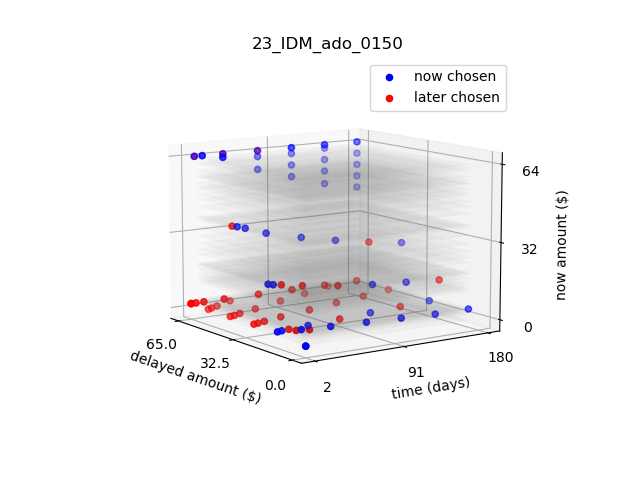

/Volumes/UCDN/datasets/IDM_ado/split/23_IDM_ado_0151/cdd/23_IDM_ado_0151_cdd.csv
   cdd_immed_wait  count
0               0    100
    cdd_delay_amt  count
0             5.0      8
1            16.5      1
2            20.0     12
3            26.0      3
4            30.5      1
5            35.0      1
6            37.5      3
7            40.0      8
8            45.0      2
9            48.0      2
10           55.0      3
11           55.5      1
12           59.0      3
13           65.0     52
   cdd_delay_wait  count
0             2.0     16
1             7.0     18
2            15.0     15
3            28.0     12
4            56.0     13
5            83.0     11
6           132.0      7
7           180.0      8
    cdd_immed_amt  count
0             0.5      2
1             1.0      1
2             1.5      1
3             2.0     44
4             2.5      1
5             3.0      1
6             3.5      1
7             4.0      2
8             4.5      1
9             5.5  

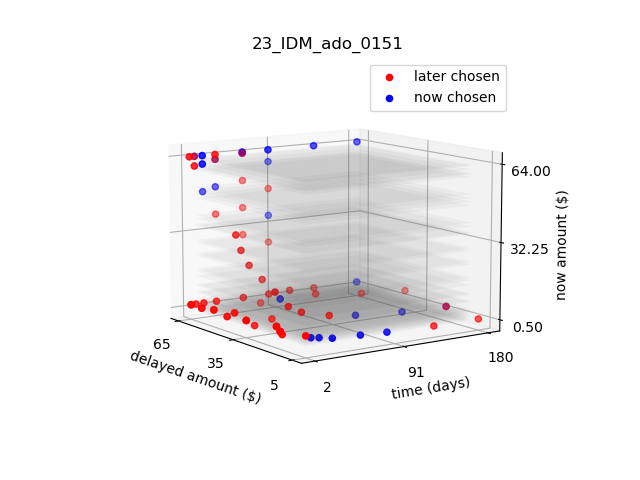

/Volumes/UCDN/datasets/IDM_ado/split/23_IDM_ado_0152/cdd/23_IDM_ado_0152_cdd.csv
   cdd_immed_wait  count
0               0    100
    cdd_delay_amt  count
0             5.0      8
1            16.0      1
2            19.0      2
3            20.0      8
4            23.0      1
5            30.0      1
6            35.0      2
7            40.0     10
8            43.0      1
9            44.0      1
10           51.5      2
11           55.0      1
12           58.0      1
13           63.5      1
14           65.0     60
   cdd_delay_wait  count
0             2.0     14
1             7.0     16
2            15.0     16
3            37.0     15
4            74.0     17
5           111.0      7
6           145.0      7
7           180.0      8
    cdd_immed_amt  count
0             0.5      1
1             1.0      2
2             1.5      1
3             2.0     34
4             2.5      1
5             3.0      2
6             4.0      2
7             4.5      1
8             5.5  

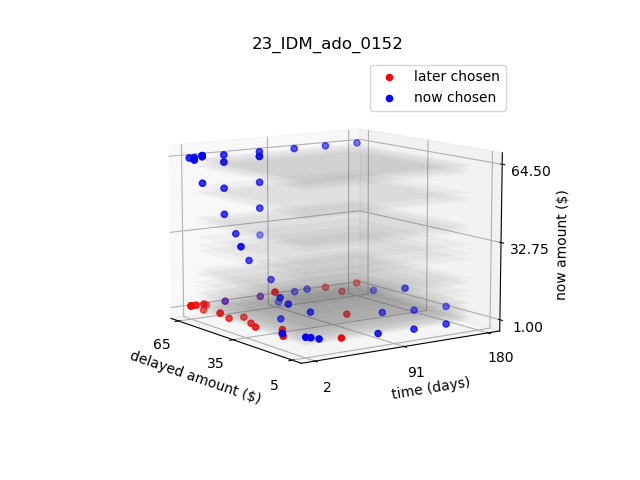

/Volumes/UCDN/datasets/IDM_ado/split/23_IDM_ado_0153/cdd/23_IDM_ado_0153_cdd.csv
   cdd_immed_wait  count
0               0    100
   cdd_delay_amt  count
0            5.0      9
1           20.0     10
2           27.0      2
3           33.5      2
4           40.0      8
5           51.0      4
6           58.0      6
7           62.5      2
8           65.0     57
   cdd_delay_wait  count
0             2.0     22
1             3.0     17
2             7.0     31
3            10.0      8
4            15.0      8
5            95.0      7
6           180.0      7
    cdd_immed_amt  count
0             0.5      6
1             1.0      2
2             1.5      2
3             2.0     41
4             3.0      4
5             4.0      1
6             5.0      2
7             5.5      1
8             8.0      1
9             9.0      1
10           10.5      2
11           11.0      2
12           18.0      1
13           22.0      1
14           29.5      3
15           42.0      6
16  

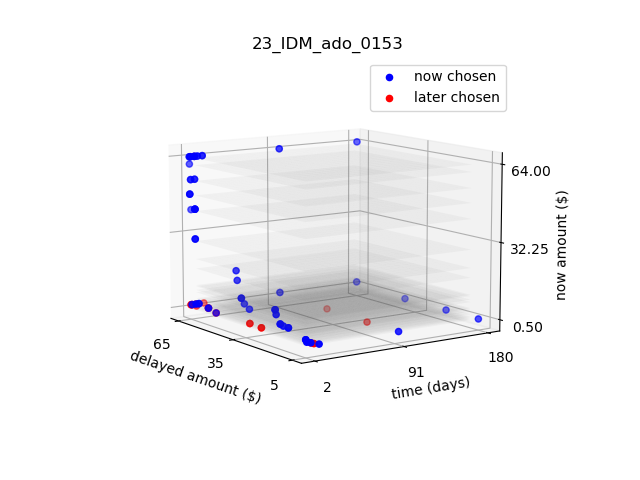

/Volumes/UCDN/datasets/IDM_ado/split/23_IDM_ado_0154/cdd/23_IDM_ado_0154_cdd.csv
   cdd_immed_wait  count
0               0    100
    cdd_delay_amt  count
0             5.0      8
1            16.0      1
2            19.0      3
3            20.0      8
4            24.0      2
5            30.0      1
6            35.0      1
7            35.5      3
8            40.0      8
9            44.0      1
10           44.5      2
11           52.0      3
12           55.0      1
13           58.0      3
14           65.0     55
   cdd_delay_wait  count
0             2.0     15
1             7.0     18
2            15.0     16
3            34.0     13
4            68.0     13
5           102.0     11
6           141.0      7
7           180.0      7
    cdd_immed_amt  count
0             0.5      1
1             1.0      2
2             1.5      1
3             2.0     43
4             2.5      1
5             3.0      2
6             4.0      2
7             4.5      1
8             5.0  

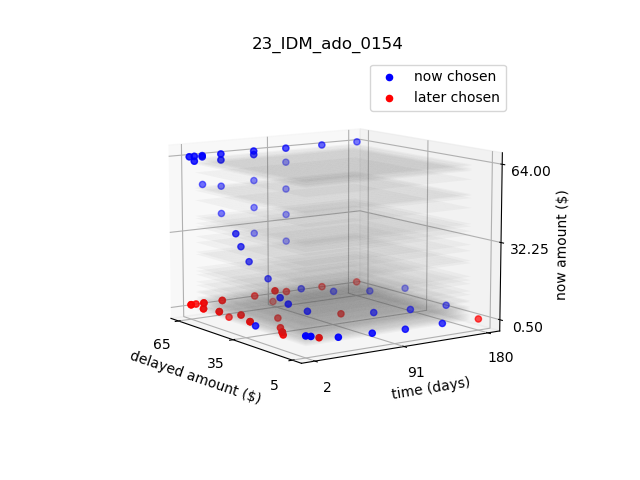

/Volumes/UCDN/datasets/IDM_ado/split/23_IDM_ado_0155/cdd/23_IDM_ado_0155_cdd.csv
   cdd_immed_wait  count
0               0    100
   cdd_delay_amt  count
0            5.0      8
1           20.0      8
2           28.0      2
3           34.5      3
4           40.0      8
5           52.0      3
6           54.0      2
7           60.5      3
8           64.5      3
9           65.0     60
   cdd_delay_wait  count
0             2.0     19
1             3.0     16
2             6.0     12
3             7.0     19
4             9.0     13
5            15.0      7
6            95.0      7
7           180.0      7
    cdd_immed_amt  count
0             0.5      6
1             1.0      3
2             1.5      1
3             2.0     38
4             2.5      2
5             4.0      1
6             5.0      1
7             5.5      2
8             8.0      1
9             8.5      1
10           10.0      1
11           10.5      1
12           11.0      1
13           17.5      1
14   

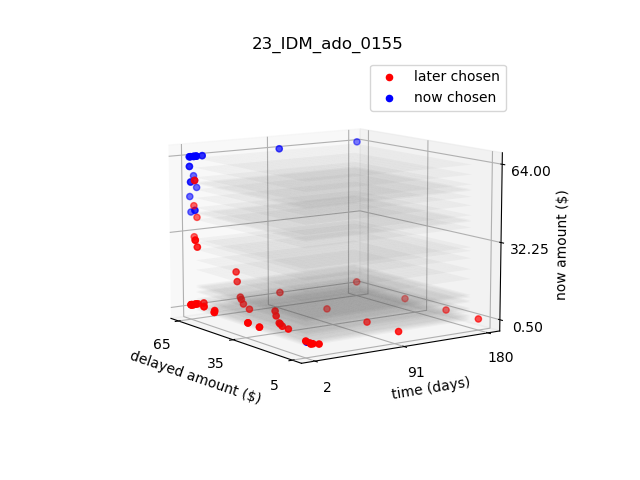

/Volumes/UCDN/datasets/IDM_ado/split/23_IDM_ado_0156/cdd/23_IDM_ado_0156_cdd.csv
   cdd_immed_wait  count
0               0    100
    cdd_delay_amt  count
0             5.0      9
1            15.5      1
2            17.0      2
3            19.5      1
4            20.0      8
5            26.5      1
6            29.0      2
7            32.0      2
8            37.0      1
9            37.5      1
10           40.0      8
11           42.5      1
12           47.0      2
13           49.0      2
14           54.0      1
15           56.5      1
16           60.0      1
17           62.0      2
18           65.0     54
   cdd_delay_wait  count
0             2.0     15
1             7.0     16
2            15.0     12
3            36.0     11
4            72.0     11
5           108.0     12
6           144.0     12
7           180.0     11
    cdd_immed_amt  count
0             1.0      2
1             1.5      1
2             2.0     41
3             3.0      1
4             4.0  

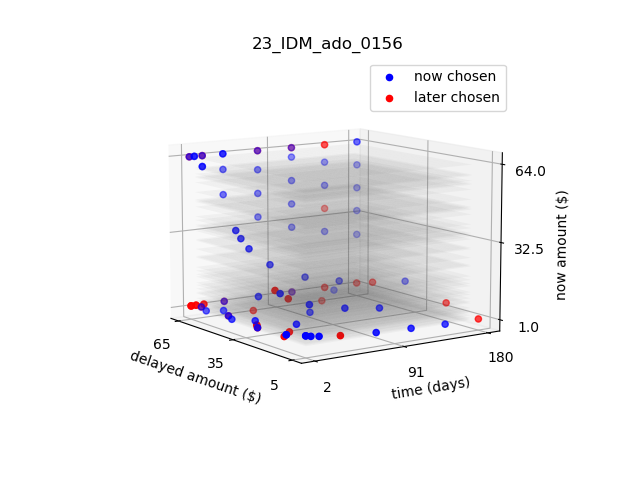

/Volumes/UCDN/datasets/IDM_ado/split/23_IDM_ado_0157/cdd/23_IDM_ado_0157_cdd.csv
   cdd_immed_wait  count
0               0    100
    cdd_delay_amt  count
0             0.0      2
1             5.0      8
2            15.0      1
3            15.5      1
4            16.0      1
5            17.5      1
6            20.0      9
7            22.5      1
8            24.5      1
9            27.0      1
10           28.5      1
11           29.0      1
12           30.0      1
13           32.5      1
14           37.0      1
15           40.0      8
16           41.5      2
17           42.5      1
18           44.0      1
19           46.0      1
20           47.5      1
21           50.5      1
22           54.5      2
23           55.5      1
24           57.5      1
25           61.0      1
26           62.5      1
27           65.0     48
   cdd_delay_wait  count
0             2.0     13
1             7.0     11
2            15.0     11
3            36.0     13
4            72.0  

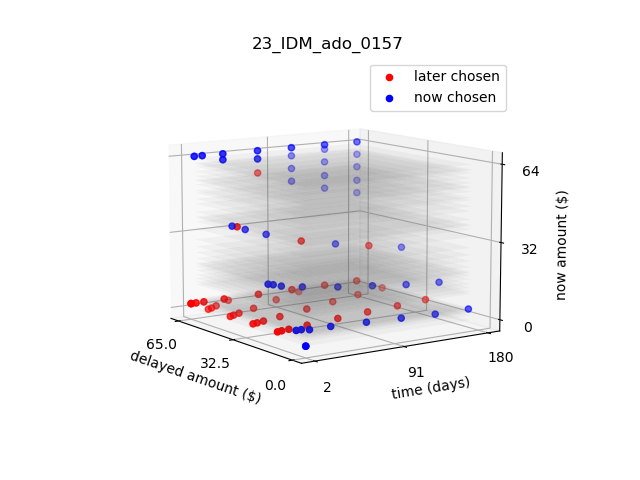

In [71]:
split_dir = '/Volumes/UCDN/datasets/IDM_ado/split/'
utility_dir = '/Volumes/UCDN/datasets/IDM_ado/utility/'

cols = ['cdd_immed_wait','cdd_delay_amt','cdd_delay_wait','cdd_immed_amt']

#get set of all good data files for analysis
good_files = sorted(glob(os.path.join(split_dir, '*/cdd/*.csv')))
if (not good_files):
    print("No good files available. Check file path.")
    sys.exit()
some_sub = [1,10,30,50,80,100,140]
for i, subj_fn in enumerate(good_files):
    # if i not in some_sub:
    #     continue
    print(subj_fn)
    count_delay_wait_immed_amt(subj_fn,cols=cols,save=False)
    plot_3D_choice(utility_dir,subj_fn,cols=cols,log=False)
    # plot_3D_choice(utility_dir,subj_fn,cols=cols,log=True)

Use the results from above to define upper and lower bounds and ylabels and titles

In [72]:

### 2D plots ...  no longer being used

# cols = ['cdd_immed_wait','cdd_delay_amt','cdd_delay_wait','cdd_immed_amt']

# # ylabels = ['Immediate $2','Immediate $5', 'Immediate $15']
# # titles = ['Delay Wait: Now', 'Delay Wait: 1 month','Delay Wait: 3 months','Delay Wait: 12 months','Delay Wait: 60 months']


# # cols defined above
# delay_amt_choice_df = pd.DataFrame(columns=['frequency','choice']+cols)

# for i, subj_fn in enumerate(good_files):
#   # delay wait
#   xcol=cols[2]
#   # immediate amount
#   ycol=cols[3]
#   xax = cols[1]
#   yax = 'cdd_choice'

#   print(subj_fn)
#   df = pd.read_csv(subj_fn)
#   df = drop_blank(df)
#   df,ycol,ylabels = bin_col(df,col=ycol,nb_steps = 4)
  
#   display(ylabels)
#   xtitle = get_labels(df,col=xcol)


#   plt.figure(i,figsize=(20,10))
#   xcol_vals = sorted(df[xcol].unique())
#   ycol_vals = sorted(df[ycol].unique())
#   index=0


#   #loop through each delay-wait subgroup for each smaller sooner amount 
#   for iy, yv in enumerate(ycol_vals):
#     for ix, xv in enumerate(xcol_vals):
#       # index = 1+iy+(len(xcol_vals)*ix)
#       # print('({},{}) with ({},{}) and index: {}'.format(ix,iy,xv,yv,index))
#       # print('title:{} ylabel: {}'.format(xtitle[ix],ylabels[iy]))
#       index += 1
#       plt.subplot(len(ycol_vals),len(xcol_vals),index)
#       plt.ylim([-0.1,1.1])
#       plt.xlim([0,1.1*df['cdd_delay_amt'].max()])
#       if (ix == 0):
#         plt.ylabel(ylabels[iy],fontsize=12)
#         plt.yticks([0,1],['0-now','1-delay'])
#       else:
#         plt.yticks([0,1])
#       if (iy == 0):
#         plt.title(xtitle[ix],fontsize=12)
#       if (iy == len(ycol_vals)-1):
#         plt.xlabel(xax,fontsize=15)
      
#       x = []
#       y = []
#       #get dataframe with the appropriate smaller sooner and delay-wait time values
#       idf = df.loc[(df[xcol] == xv) & (df[ycol] == yv)]
#       if not len(idf):
#         continue
#       x = x + idf[xax].tolist()
#       y = y + idf[yax].tolist()
      
#       #used to fill .csv file for each participant's choices
#       delay_amt_choice, count = count_tuples(list(zip(x,y)))
#       this_df = pd.DataFrame(columns=cols)
#       this_df["frequency"] = count
#       this_df["choice"] = delay_amt_choice
#       this_df[xcol] = xtitle[ix]
#       this_df[ycol] = ylabels[iy]
#       delay_amt_choice_df = pd.concat([delay_amt_choice_df,this_df],ignore_index=True)

#       #sort by x and y in order to connect lines properly on final plots
#       x,y = zip(*sorted(zip(x,y)))
#       plt.plot(x,y,'*-')


#   subj = get_subject(subj_fn)

#   fn = os.path.join(utility_dir,subj,'cdd/{}_cdd_delay_amt_choice.csv'.format(subj))
#   print("Saving to: {}".format(fn))
#   delay_amt_choice_df.to_csv(fn)
#   # print(delay_amt_choice_df)
#   plt.suptitle(os.path.basename(subj_fn).replace('_cdd.csv',''), fontsize=25)
#   plt.tight_layout()
#   fig_fn = os.path.join(utility_dir,subj,'cdd/{}_cdd_plot_delay_amt_choice.png'.format(subj))
#   print("Saving to: {}".format(fig_fn))
#   plt.savefig(fig_fn)
#   plt.show()
#   #sys.exit()